Ejemplo Series temporales



In [3]:
import pickle

import scipy.stats
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib as mpl
from sklearn import svm
from sklearn import ensemble
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline

Utilizaremos los datos de la [calidad del aire](http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/principals_contaminants/index.html) del Eixample de Barcelona desde 2011, concretamente del contaminante dióxido de nitrógeno (NO2). Los datos son medidos por la Red de Vigilancia y Previsión de la Contaminación Atmosférica y se pueden obtener para otras estaciones, contaminantes y períodos [aquí](http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/vols-saber-que-respires/descarrega-de-dades/index.html).

Empezaremos leyendo los datos:

In [4]:
df = pd.read_csv('NO2_Eixample_2011_2019.csv')
print("Number of rows and columns:", df.shape)
print("Column names:", list(df.columns))
df.head(3)

Number of rows and columns: (3214, 40)
Column names: ['codi_eoi', 'nom_estacio', 'data', 'magnitud', 'contaminant', 'unitats', 'tipus_estacio', 'area_urbana', 'codi_ine', 'municipi', 'codi_comarca', 'nom_comarca', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24', 'altitud', 'latitud', 'longitud', 'geocoded_column']


,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
0,8019043,Barcelona (Eixample),2014-10-03T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,60.0,60.0,36.0,39.0,70.0,70.0,67.0,95.0,97.0,106.0,92.0,86.0,102.0,90.0,84.0,93.0,92.0,68.0,70.0,100.0,95.0,97.0,81.0,69.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
1,8019043,Barcelona (Eixample),2014-09-02T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,26.0,32.0,45.0,48.0,40.0,50.0,47.0,67.0,68.0,67.0,62.0,61.0,62.0,65.0,46.0,49.0,60.0,59.0,70.0,80.0,74.0,61.0,37.0,20.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2,8019043,Barcelona (Eixample),2014-05-16T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,25.0,17.0,22.0,25.0,39.0,35.0,46.0,90.0,93.0,59.0,54.0,60.0,64.0,60.0,53.0,50.0,67.0,74.0,76.0,77.0,70.0,75.0,69.0,48.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Convertimos la columna "data" (=fecha) a tipo *datetime* y ordenamos los datos temporalmente:

In [5]:
df["data"] = pd.to_datetime(df["data"])
df.sort_values("data", inplace=True)       #https://datagy.io/pandas-sort-values/
df.head(3)

,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
2912,8019043,Barcelona (Eixample),2011-01-17,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2704,8019043,Barcelona (Eixample),2011-01-18,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2805,8019043,Barcelona (Eixample),2011-01-19,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Vemos que, para cada fila, tenemos las medidas de N02 en µg/m3 para cada hora del día. Para simplificar el análisis, utilizaremos solamente la media diaria, que pasamos a calcular: 

In [6]:
colNs_hourly_measurements = ["h%02d" % h for h in range(1,25)]
print(colNs_hourly_measurements)
df["mean_day"] = df[colNs_hourly_measurements].mean(axis=1)
df[["data", "mean_day"] + colNs_hourly_measurements].head()

['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']


,data,mean_day,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
2912,2011-01-17,98.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0
2704,2011-01-18,127.083333,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0
2805,2011-01-19,117.045455,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0
2969,2011-01-20,71.333333,92.0,88.0,84.0,72.0,74.0,59.0,65.0,65.0,78.0,65.0,62.0,68.0,59.0,58.0,59.0,69.0,73.0,80.0,82.0,70.0,70.0,74.0,67.0,79.0
2831,2011-01-21,75.875000,54.0,41.0,40.0,40.0,31.0,29.0,52.0,88.0,105.0,88.0,74.0,71.0,64.0,79.0,82.0,77.0,86.0,106.0,118.0,120.0,111.0,104.0,92.0,69.0


Hay días, como el primero del conjunto de datos, en los que muchas horas no tienen valores válidos. Esto puede resultar en medias diarias muy desviadas. Por tanto, eliminaremos los días con varias medidas inválidas:

In [7]:
print("Number of rows before:", df.shape[0])
df = df[df[colNs_hourly_measurements].isna().sum(axis=1)<5]
print("Number of rows after:", df.shape[0])

Number of rows before: 3214
Number of rows after: 3146


Representamos la serie temporal, compuesta sólo por la medida media que hemos creado, y como índice la columna que nos indica la fecha:

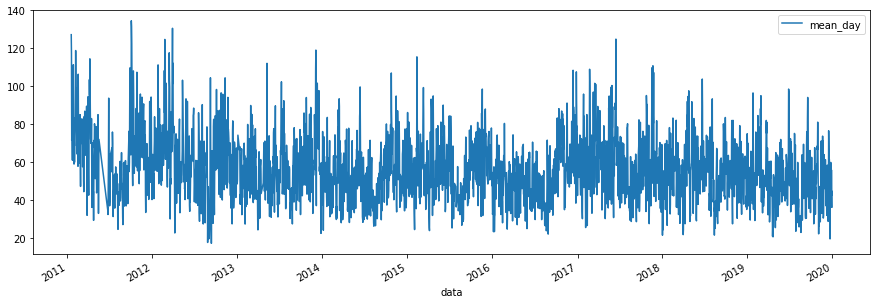

In [8]:
data = df[["data", "mean_day"]].set_index("data")
data.plot(figsize=(15, 5));

Vemos que la variación diaria introduce mucho ruido que no es interesante para analizar la evolución temporal del contaminante en una escala temporal más larga. Por consiguiente, utilizaremos la media de la medida para cada mes en vez de los valores diarios:

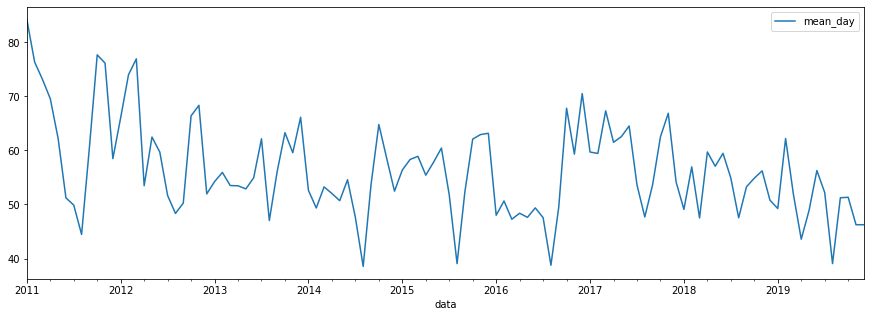

In [9]:
data = df[["data", "mean_day"]].set_index("data").resample("1M").mean()
data.plot(figsize=(15, 5));

Como se puede apreciar, la serie temporal de este contaminante es bastante irregular, pero se intuye cierta heterocedasticidad, tendencia, periodo y ruido, los cuales analizaremos a lo largo de este ejercicio.

Antes de empezar a tratar las diferentes componentes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [10]:
date_min_test = "2018-01-01"
TEST_SIZE = len(data[data.index>=date_min_test])
# train and test are dataframes that contain the values and a datetime index:
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
# x_train and x_test only contain the values:
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((84, 1), (84,), (24, 1), (24,))

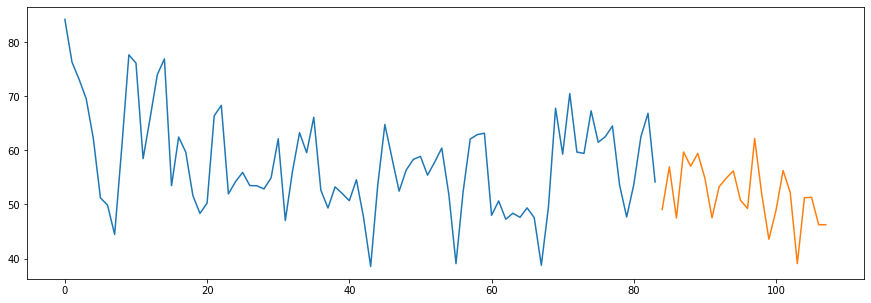

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train) 
ax.plot(x_test, test);

## 1.1 Componentes de la serie temporal

###  Heterocedasticidad

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo. En nuestro caso, observamos que tenemos una cierta heterocedasticidad, ya que la amplitud de onda disminuye ligeramente con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

Vamos a transformar los datos para eliminar la heterocedasticidad. Para hacerlo debemos transformar los datos aplicando la función que consideremos que elimina mejor la heterocedasticidad en el dataset, provaremos con las tres funciones siguientes: 

- exponencial
- logarítmica
- raiz cuadrada
    
y decidiremos cual de las tres funciona mejor para eliminar la heterocedasticidad. Estas funciones ya están implementadas en <i>numpy</i>. 
    
Mostrarmose gráficamente el dataset transformado.
</div>

Graficamos cada función, logarítmica, exponencial y raíz cuadarada. Se recomienda prestar atención a la escala del eje de ordenadas (eje Y), ya que los resultados hay que analizarlos con esta perspectiva (es decir, analizar la magnitud de la variación de la variabilidad de la función tras la transformación). Nótese aquí que la segunda transformación (función exponencial) el rango del eje Y es desde cero hasta $e^{36}$, un rango amplísimo, especialmente comparándolo con los otras dos transformaciones.

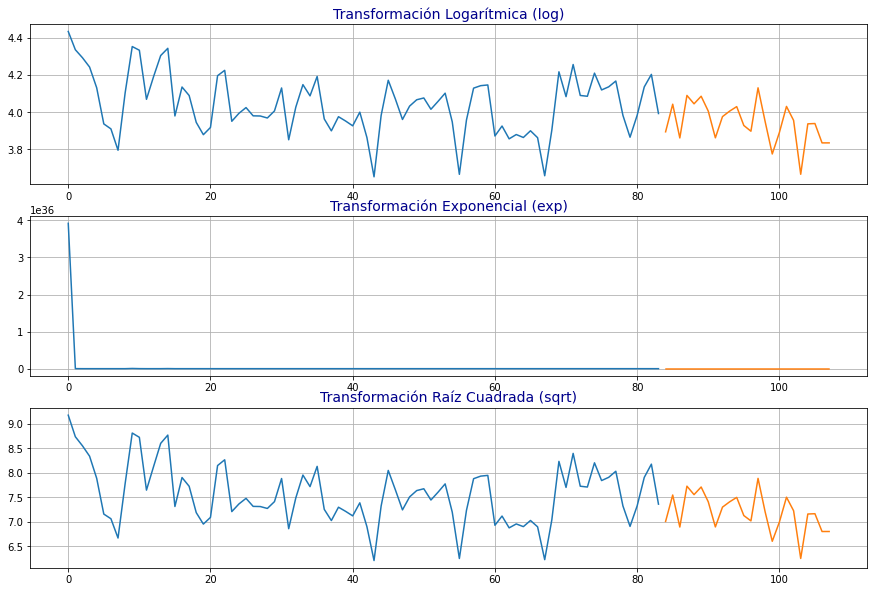

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
ax1 = plt.subplot(311)
ax1.plot(x_train, np.log(train))
ax1.plot(x_test, np.log(test));
ax1.set_title('Transformación Logarítmica (log)', fontsize = 14, color = 'darkblue')
ax1.grid(True)

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(x_train, np.exp(train))
ax2.plot(x_test, np.exp(test))
#ax2.set_ylim(9.3*np.exp(1)**16, 1.04*np.exp(1)**27)
ax2.set_title('Transformación Exponencial (exp)', fontsize = 14, color = 'darkblue')
ax2.grid(True)

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(x_train, np.sqrt(train))
ax3.plot(x_test, np.sqrt(test));
ax3.set_title('Transformación Raíz Cuadrada (sqrt)', fontsize = 14, color = 'darkblue')
ax3.grid(True)

#plt.show()

plt.show()

Gráficamente observamos que la menor disminución de varianza corresponde a la transformación logarítmica, seguida de la raíz cuadrada. Para el análisis debemos centrarnos en este caso en la magnitud (rango) del eje Y. Aunque pudiera parecer a primera vista que la transformación exponencial hace cero la varianza esto no es así, se trata simplemente de un efecto visual ya que la transformación eleva tanto la magnitud (el rango de valores) que al presentarlo en una gráfica dá una impresión que podría llevar a confusión. Para cerciorarnos de nuestras asunciones, calculamos algunos estadísticos tras las transformaciones y visualizamos una tabla (un dataframe Pandas). Ahora vemos <u>cláramente</u> que la mejor transformación (menor varianza) corresponde a la transformación mediante la función logarítmica.

In [13]:
resultados = []
resultados.append([scipy.stats.describe(np.log(train)).minmax[0][0], scipy.stats.describe(np.log(train)).minmax[1][0], scipy.stats.describe(np.log(train)).mean[0], scipy.stats.describe(np.log(train)).variance[0]])
resultados.append([scipy.stats.describe(np.exp(train)).minmax[0][0], scipy.stats.describe(np.exp(train)).minmax[1][0], scipy.stats.describe(np.exp(train)).mean[0], scipy.stats.describe(np.exp(train)).variance[0]])
resultados.append([scipy.stats.describe(np.sqrt(train)).minmax[0][0], scipy.stats.describe(np.sqrt(train)).minmax[1][0], scipy.stats.describe(np.sqrt(train)).mean[0], scipy.stats.describe(np.sqrt(train)).variance[0]])

#resultados
heterostedasticidad = pd.DataFrame(resultados, columns=['min', 'max', 'media', 'varianza'], index=['log', 'exp', 'sqrt'])
heterostedasticidad.head()

,min,max,media,varianza
log,3.651526e+00,4.433898e+00,4.041146e+00,2.493408e-02
exp,5.430609e+16,3.920173e+36,4.679935e+34,1.829376e+71
sqrt,6.207529e+00,9.179281e+00,7.565928e+00,3.586901e-01


### Tendencia

La tendencia es el comportamento que tiene los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una ligera tendencia lineal decreciente (mejor para nuestra salud). En este apartado debemos eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Observando la serie podemos apreciar que tenemos una ligera tendencia lineal a la baja:  
    - Vamos a intentar ajustar una regresión lineal a los datos (con la heterocedasticidad ya eliminada). Esta será la tendencia que asumimos que tienen los datos.   
    - Eliminaremos la tendencia de los datos, sustrayendola a los datos que ya tienen la heterocedasticidad eliminada.  
    - Mostraremos gráficamente los datos sin tendencia.
<br><br>



In [14]:
# Efectuamos la transformación en ambos sets: train y test.
trainlog = np.log(train)
testlog = np.log(test)

In [15]:
# Regresión ordinaria - mínimos cuadráticos ordinarios (OSLR)
regOLSR = LinearRegression(normalize = True, fit_intercept=True).fit(np.arange(trainlog.shape[0]).reshape((-1,1)), trainlog['mean_day'])
regOLSR.score(trainlog, x_train)

print('Coeficiente del modelo de tendencia={} e intercepta el eje Y en {}'.format(regOLSR.coef_[0],regOLSR.intercept_))

Coeficiente del modelo de tendencia=-0.001618953511089976 e intercepta el eje Y en 4.108332824727306


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Vemos la ligerísima (casi cero) pendiente negativa (-0.0016) y el corte en ordenadas (4.1). Calculamos las predicciones del conjunto de test transformado (log) a partir de la recta.

In [16]:
prediccionesNO2 = regOLSR.predict(np.arange(trainlog.shape[0]).reshape(-1,1))

# Hacemos lo mismo con el set de test para trabajar con ella más adelante (apartado SARIMA)
prediccionesNO2_test = regOLSR.predict(np.arange(testlog.shape[0]).reshape(-1,1))

Mostramos los datos con la tendencia y la recta de regresión ajustada, <u>antes</u> de eliminarla.

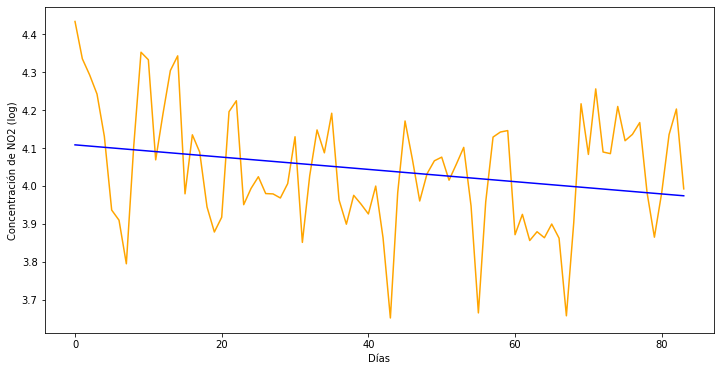

In [17]:
plt.figure(num=1, figsize=(12, 6)) 
plt.plot(trainlog['mean_day'].to_numpy(), color='orange')
plt.plot(prediccionesNO2, color='blue') 
plt.xlabel('Días') 
plt.ylabel('Concentración de NO2 (log)')
ax = plt.gca()
plt.show()

A continuación eliminamos la tendencia restando observaciones y predicciones (tendencia) generadas por el modelo lineal (OLSM) y obtenemos la gráfica de los datos <u>*sin* tendencia</u>. 
A partir de los datos de tendencia general podemos obtener los datos residuales, que se definen como los datos obtenidos a partir de sustraer la tendencia general de los datos originales, tal y como podemos ver en el siguiente celda y gráfico.

In [18]:
# Calculamos los datos sin tendencia restando datos reales (train) - predicciones para train.
residuosNO2 = trainlog['mean_day'] - prediccionesNO2

# Dado que se utilizan más adelante en este ejercicio, calculamos los datos de test sin tendencia restando datos reales (test) - predicciones para test.
residuosNO2_test = testlog['mean_day'] - prediccionesNO2_test

# Para el apartado posterior recogemos los residuos (valores - predicciones) en una variable: train_log_trend para train 
train_log_trend = residuosNO2
# De la misma forma recogemos test_log_trend para el set de test sin tendencia (valores test - predicciones test)
test_log_trend = residuosNO2_test

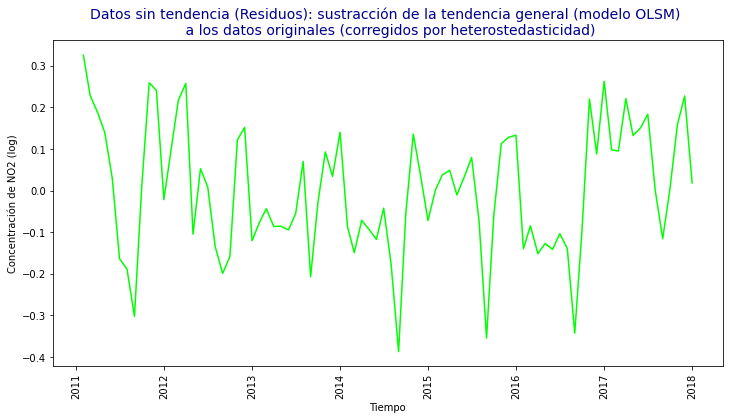

In [19]:
plt.figure(figsize=(12, 6))  
plt.plot(residuosNO2, color ='lime')
plt.xlabel('Tiempo') 
plt.ylabel('Concentración de NO2 (log)')
plt.title('Datos sin tendencia (Residuos): sustracción de la tendencia general (modelo OLSM) \n a los datos originales (corregidos por heterostedasticidad)', fontsize = 14, color = 'darkblue')
ax = plt.gca()
plt.xticks(rotation=90) 
plt.show()

Aunque no es fácil de observar visualmente, vemos cómo la gráfica es ahora más plana (menos pendiente, si cabe, de una hipotética línea 'media' que atravesase el gráfico). En especial vemos como los años son ahora "más parecidos" y cómo varían de forma más uniforme (amplitudes más parecidas) que en los datos originales. Además la escala del eje de ordenadas obviamente es mucho menor rango (-0.3, 0.3) ya que hemos eliminado la tendencia general.

### Estacionalidad

Definimos estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar la estacionalidad, la cual eliminaremos . 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
En primer lugar tenéis que encontrar el ciclo, es decir, cada cuando se repiten los datos. Para encontrarlo podéis usar podemos usar la autocorrelacion (<i>numpy</i> te permite obtener los coeficientes de correlación). La idea es que se tiene que comparar:  
    
- La serie original con la serie empezando en el segundo punto (es decir, serie[1:])  
- La serie original con la serie empezando en el tercer punto (es decir, serie[2:])  
- ...
    
En el momento en que vuelva a empezar el ciclo, la serie será muy parecida a la serie original, y, por lo tanto, la correlación será muy elevada. El punto donde la correlación sea máxima, será el ciclo de la serie. Esto es una forma de encontrar el ciclo de una serie temporal pero no la única.  

Mostrar gráficamente los coeficientes de los 22 primeros valores de autocorrelación y determinar su valor máximo, este será nuestra estacionalidad.
    
<u>NOTA</u>: Si usais <i>numpy</i> para encontrar los coeficientes de correlación, las dos series que comparéis deben de tener la misma longitud. Para representar la serie original podéis eliminar los valores del final para que tenga la misma longitud que la serie "movida". Por ejemplo, en el primer caso podéis comparar serie[1:] con serie[:-1].
</div>

En primer lugar obtenemos todos los años de los datos, utilizando Pandas (DatetimeIndex)

In [20]:
pd.DatetimeIndex(residuosNO2.index[1:24]).year

Int64Index([2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
            2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
            2012],
           dtype='int64', name='data')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


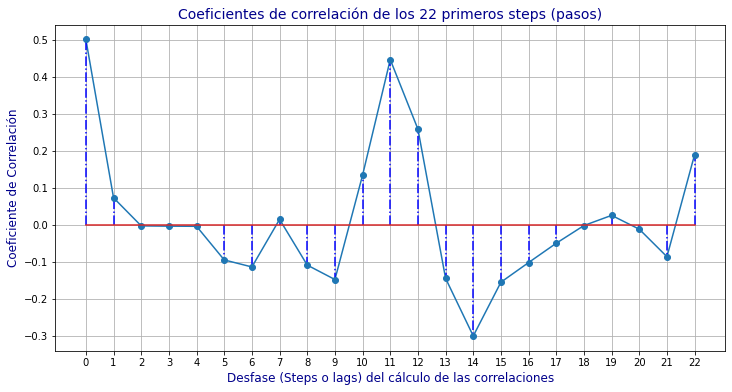

In [21]:
#Cálculo de los 22 primeros coeficientes de correlacion

# Lista vacía para los coeficientes
coef_correl =[]

# Iteramos por el rango de 1 (empezar en 0 nos daría un error) hasta el 24 para obtener 22 muestras)
for i in range (1, 24):
    
    coef_correl.append(np.corrcoef(residuosNO2[i:], residuosNO2[:-i])[0,1])

fig, ax = plt.subplots(1,1, figsize = (12,6))
ax.plot(range(len(coef_correl)), coef_correl)

ax.set_title("Coeficientes de correlación de los 22 primeros steps (pasos)", fontsize = 14, color = 'darkblue')
ax.set_ylabel("Coeficiente de Correlación", fontsize = 12, color = 'darkblue')
ax.set_xlabel("Desfase (Steps o lags) del cálculo de las correlaciones", fontsize = 12, color = 'darkblue')
ax.stem(range(len(coef_correl)), coef_correl, linefmt='b-.')
ax.set_xticks(range(23))
ax.set_xticklabels(range(23));

ax.grid();

Vemos que los ciclos se presentan desde el paso 0 hasta el paso 11 (11 pasos). Si seguimos, obtenemos otro máximo en el paso 22 (11 pasos de ciclo de nuevo).

Para comprobar en cierta medida nuestros resultados, se presentan a continuación los resultados que el paquete statsmodel nos ofrece mediante su api, simplemente implementando la función `seasonal_decompose` del módulo tsa y sacando las gráficas. Es interesante observar cómo la tendencia corresponde a lo calculado anteriormente, una ligera pendiente negativa (véase el eje Y para ver que la magnitud del descenso es muy pequeña). Otro punto interesante es el grafico de 'estacionalidad' (tercer gráfico: seasonal). Aquí podemos intuir que en todos los años existe una especie de 'lógica': en los primeros meses del año se produce un descenso acusado para luego aumentar mucho hasta Julio-Agosto (período vacacional?) donde de nuevo bajan mucho las emisiones hasta volver a subir en Septiembre-Octubre aproximadamente (final del verano-vacaciones).

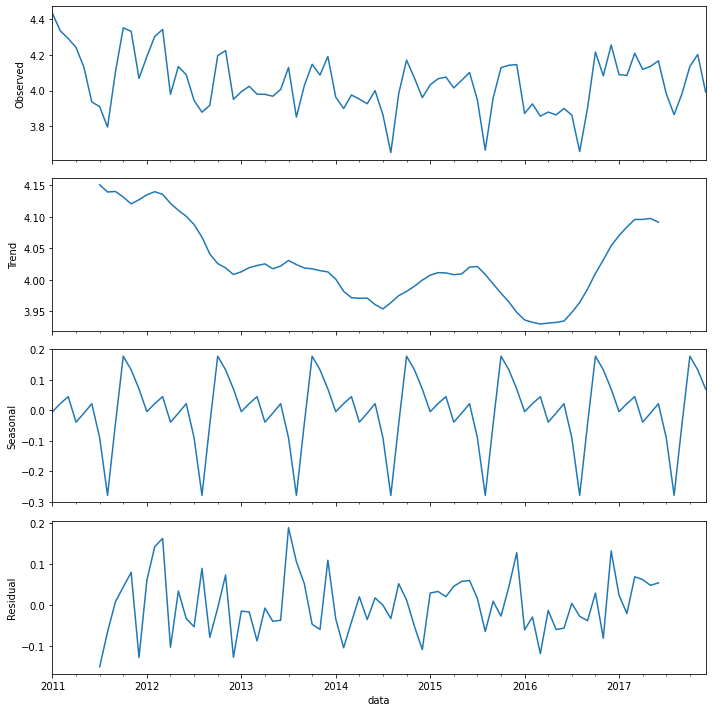

In [25]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(trainlog['mean_day'], model ='additive')
fig = decomposition.plot()
plt.rcParams['figure.figsize']=[12.0,12.0]

Por último utilizamos el test de Dickey-Fuller (ADF) para tratar de determinar si la serie es no-estacionaria. En este caso la hipótesis nula $H_{0}: (p-valor > 0.05)$ La serie tiene una raíz unitaria, es decir no es estacionaria. Si no podemos rechazar esta hipótesis podemos decir que (con mucha probabilidad) la serie no es estacionaria. En este caso el p-valor (0.266) es bastante mayor que 0.05 (95% de confianza) y por tanto *no* podemos rechazar $H_{0}$, es decir, estadísticamente podemos estar seguros de que la serie es no-estacionaria. Incluso con valores críticos mayores (como vemos en los resultados de 1%), el resultado de no-estacionalidad se mantiene.
También se puede expresar lo mismo utilizando el estadístico calculado, en este caso el valor del estadístico -2.047, es siempre mayor que los 'critical values' (incluso el mayor que sería 10%) por tanto no podemos rechazar $H_{0}$ con lo cual estadísticamente la serie es <u>no-estacionaria</u> con una gran probabilidad.

In [26]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('===== Resultados del test de Dickey-Fuller: ===\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico del Test','p-value (p-valor)','#Lags Used (ciclo)','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Valor Crítico (%s)'%key] = value
    print (dfoutput)
    
adf_test(trainlog['mean_day'])

===== Resultados del test de Dickey-Fuller: ===

Estadístico del Test                  -2.047238
p-value (p-valor)                      0.266252
#Lags Used (ciclo)                    11.000000
Número de observaciones utilizadas    72.000000
Valor Crítico (1%)                    -3.524624
Valor Crítico (5%)                    -2.902607
Valor Crítico (10%)                   -2.588679
dtype: float64


Por último, también podemos volver a utilizar la API de statsmosdels para obtener y separar la tendencia y componente cíclico. Lo presentamos a continuación, con resultados similares.

In [27]:
import statsmodels.api as sm
wft_ciclo, wft_tend = sm.tsa.filters.hpfilter(trainlog['mean_day'])
trainlog['tendencia'] = wft_tend

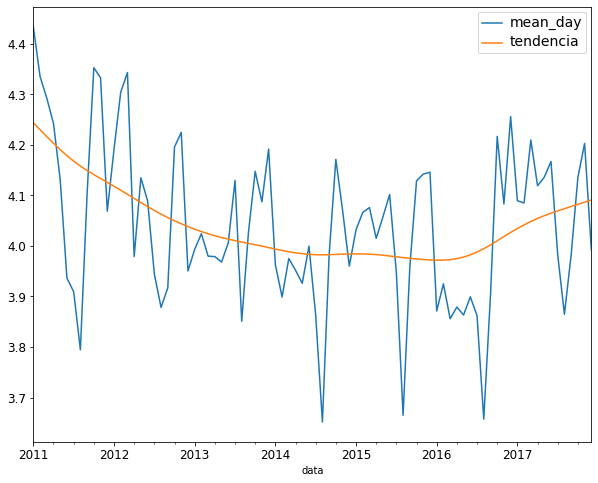

In [28]:
# graficando la variacion del precio real con la tendencia.
trainlog[['mean_day', 'tendencia']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

### Aplicar un modelo SARIMA

Para tratar la estacionalidad aplicaremos un modelo SARIMA. Las siglas corresponden a "stationality ARIMA", es decir, un modelo ARIMA con estacionalidad (la que acabamos de encontrar).

El modelo ARIMA nos va a permitir tratar el ruido que queda al eliminar la heterocedasticidad, tendencia y estacionalidad. Para hacerlo tiene en cuenta las siguientes componentes:

- AR: auto-regressive, se denomina *p*. Tiene en cuenta la correlación con sus lags, es decir, mira si las observaciones pasadas afectan para calcular el siguiente punto. 
- I: integrated, se denomina *d*. Es el orden de diferenciación, en nuestro caso no es necesario, puesto que la serie ya no tiene heterocedasticidad ni tendencia.
- MA: moving-average, se denomina *q*. Tiene en cuenta la correlación con los lags de los errores, es decir, una vez se ha aplicado el modelo, mira los errores del modelo versus los datos reales.

Para más información sobre los ARIMA podéis consultar este link: https://otexts.com/fpp2/arima.html

Los modelos SARIMA dependen de varios parámetros (p,d,q)(P,D,Q)s, donde los primeros (minúsculas) corresponden a AR, I, MA de la serie normal, u los segundos (mayúsculas) a AR, I, MA con estacionalidad. 

Para encontrar estos parámetros tenemos que mirar los gráficos PACF (<i>partial autocorrelation function</i>) y ACF (<i>autocorrelation function</i>).

El gráfico PACF nos determina el parámetro *p*, es decir, la AR.

<u>**Elección de parámetros p y P**</u>  En un apartados anteriore he asignado una variable train_log_trend a los datos sin heterostedasticidad ni tendencia. P

Vemos que las conclusiones son: al comenzar hay dos valores fuera del intervalo de los cuales el primero despreciamos. Así, en el primer ciclo (primeros 12 puntos, contando el primero) hay tres valores fuera del intervalo de confianza, uno de ellos justo en la frontera pero un poquito fuera, podríamos coger p =  1 o 2. Al repetirse el ciclo, es decir, a partir del valor 11, hay dos valores (y uno casi casi dentro, pero lo consideramos fuera) fuera del intervalo, con lo cual nos decidimos por P = 2.

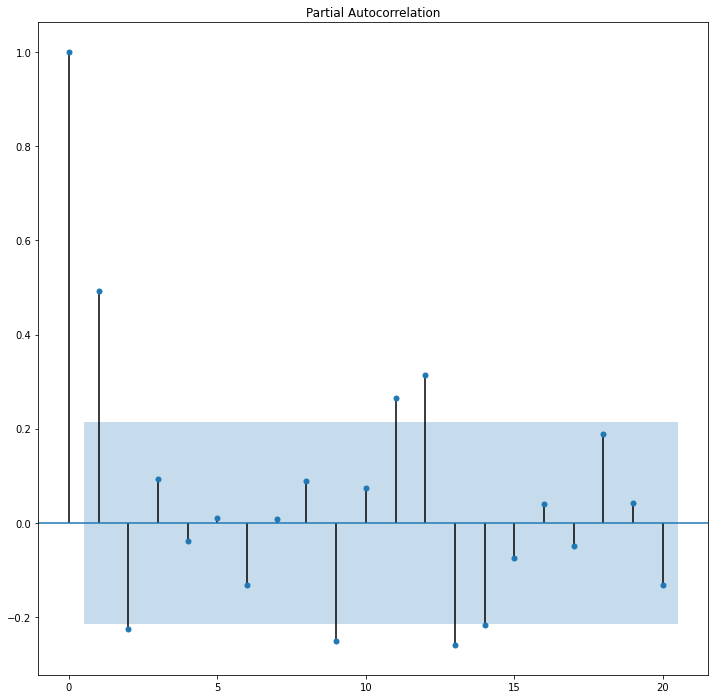

In [29]:
# Los datos sin heterocedasticidad ni tendencia se han asignado previamente a la variable train_log_trend
plot_pacf(train_log_trend)
plt.show()

<< <u>Esta celda es la original del Enunciado</u>>>  
Para leer este gráfico, simplemente nos tenemos que fijar en los valores que salen fuera del intervalo de confianza (zona azul).

Nada mas empezar hay dos valores fuera del intervalo. De todos modos el primero no se debe tener en cuenta, puesto que mira la correlación de un valor consigo mismo, y esta siempre será 1. Si no tenemos en cuenta este primer valor, en el primer ciclo (primeros 11 puntos) hay tres valores fuera del intervalo de confianza, pero uno de ellos justo en la frontera y además ya han entrado algunos lags en la zona de significación, con lo cual escogemos **p = 1**. También podríamos probar con p=1 o p=3.

Cuando se repite el ciclo, es decir, a partir del valor 11, hay tres valores claramente fuera del intervalo, con lo cual **P = 3**. 

Veamos ahora el gráfico ACF, este determinará el valor de *q*.

<u>**Elección de parámetros q y Q**</u> Al igual que para p y P, en el apartado anterior, he asignado una variable train_log_trend a los datos sin heterostedasticidad ni tendencia. 

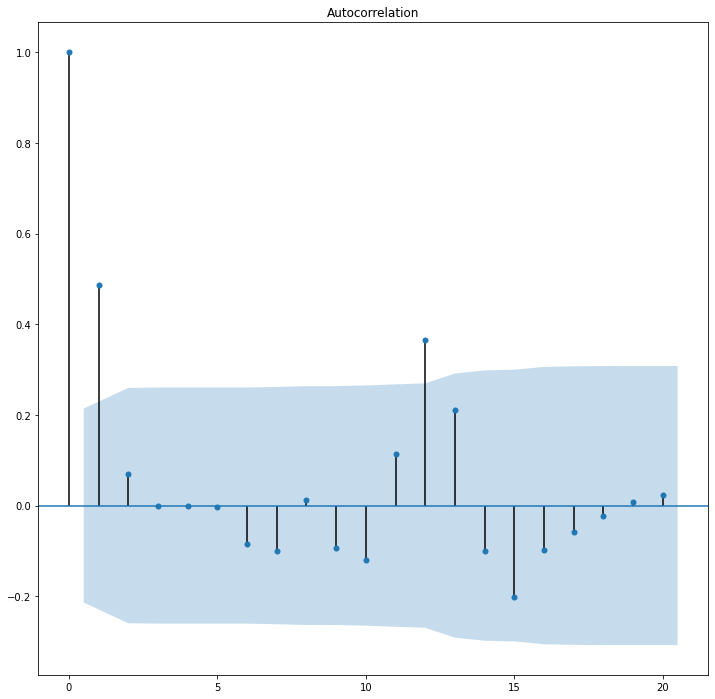

In [30]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_log_trend
plot_acf(train_log_trend)
plt.show()

<< <u>Esta celda es la original del Enunciado</u>>>  
Este gráfico se lee igual que el anterior. 

Ignorando el primer lag, vemos que al empezar hay un valor fuera del intervalo, con lo cual **q = 1**. Cuando se repite el ciclo, es decir, a partir del valor 11, solo hay un valor fuera del intervalo, con lo cual **Q = 1** ( o cero).

Como los datos no tienen ni tendencia ni heterocedasticidad, **d = D = 0**.

Como hemos visto en el apartado anterior, el ciclo es 12, con lo cual **s = 12**.

<u>**Elección de parámetros q y Q y s **</u> En el ejercicio he asignado una variable train_log_trend a los datos sin heterostedasticidad ni tendencia. 
Vemos que al comenzar el ciclo (la barra cero la obviamos) existe un único punto fuera tanto en el primer ciclo como en el segundo (partir de 11) con lo qual tanto **q =  Q = 1** y **s = 12 **.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Aplica un modelo SARIMA a los datos sin heterocedasticidad ni tendencia. Puedes usar SARIMAX (de <i>statsmodels.tsa.statespace.sarimax</i>) con los parámetros que acabamos de ver. 
    
Mostrar gráficamente el resultado del modelo en el dataset de train junto con la serie original para comparar si se ajusta bien.
</div>

Primero obtenemos la fecha más antigua con min(). Esto nos servirá más adelante para las gráficas.

In [53]:
min(train_log_trend.index)

Timestamp('2011-01-31 00:00:00', freq='M')

Definimos el modelo SARIMAX y pasamos los parámetros establecidos en los dos apartados anteriores: p=1,P=3,q=1,Q=1 y s=12.

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Parámetros de acuerdo al análisis anterior
orden = (3, 0, 1)
orden_estacional = (3, 0, 1, 12)

# Definimos el modelo SARIMA
modeloSARIMAX = SARIMAX(train_log_trend, order = orden, seasonal_order = orden_estacional)

# Ajustamos el modelo
resultadosSARIMAX = modeloSARIMAX.fit()

# Sacamos un resumen para ver si tiene sentido
print(resultadosSARIMAX.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           mean_day   No. Observations:                   84
Model:             SARIMAX(3, 0, 1)x(3, 0, 1, 12)   Log Likelihood                  68.669
Date:                            Wed, 04 May 2022   AIC                           -119.339
Time:                                    22:56:04   BIC                            -97.461
Sample:                                01-31-2011   HQIC                          -110.544
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0148      0.381     -0.039      0.969      -0.762       0.733
ar.L2          0.3400      0.257   

Pasamos a predecir los valores del intervalo temporal del conjunto de TRAIN (2011-2017) y sacamos las gráficas de predicciones vs. datos reales.

In [55]:
predorigSARIMAX = resultadosSARIMAX.predict(start=min(train_log_trend.index), end=max(train_log_trend.index))

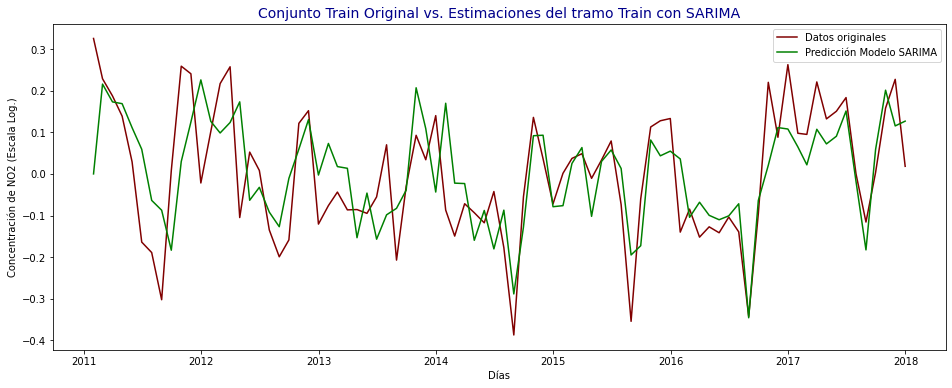

In [56]:
plt.figure(num=1, figsize=(16, 6)) 
plt.plot(train_log_trend, color='maroon', label = 'Datos originales')
plt.plot(predorigSARIMAX, color='green', label = 'Predicción Modelo SARIMA') 
plt.xlabel('Días') 
plt.ylabel('Concentración de NO2 (Escala Log.)')
ax = plt.gca()
plt.title("Conjunto Train Original vs. Estimaciones del tramo Train con SARIMA", fontsize = 14, color = 'darkblue')
plt.legend();
plt.show()

Visualmente vemos que no ajusta demasiado bien. En general hay una distancia casi siempre entre predicciones y datos y en diversos puntos se identifican manifiestas diferencias como por ejemplo en la segunda mitad del año 2013 y comienzos de 2014. Calculamos la precisión (medida conforme a $R^2$), simplemente como referencia.

In [57]:
from sklearn.metrics import r2_score
print("R^2 del modelo SARIMA en los datos TRAIN: {}".format(r2_score(train_log_trend,predorigSARIMAX)))

R^2 del modelo SARIMA en los datos TRAIN: 0.4352231330999823


## Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Seguiremos los siguientes pasos:

   - Generar la predicción con el SARIMA
   - Añadir tendencia
   - Añadir heterocedasticidad

###  Predicción SARIMA

Utilizaremos el modelo SARIMA que hemos fitado antes para predecir los dos próximos años.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Generamos las previsiones para dos años de test mediante el modelo SARIMA ajustado en el apartado anterior.

Hacemos un gráfico de toda la serie temporal (sin heterocedasticidad ni tendencia), diferenciando con dos colores diferentes la serie real en el conjunto de train y las previsiones del modelo en los dos años del conjunto de test.
</div>

Pasamos a predecir los dos años de test con nuestro modelo, introduciendo las fechas start y end en la función predict(). A continuación graficamos con diferentes colores para identificar datos reales de predicciones.

In [58]:
pred2añosSARIMAX = resultadosSARIMAX.predict(start=min(test_log_trend.index), end=max(test_log_trend.index), dynamic=True)

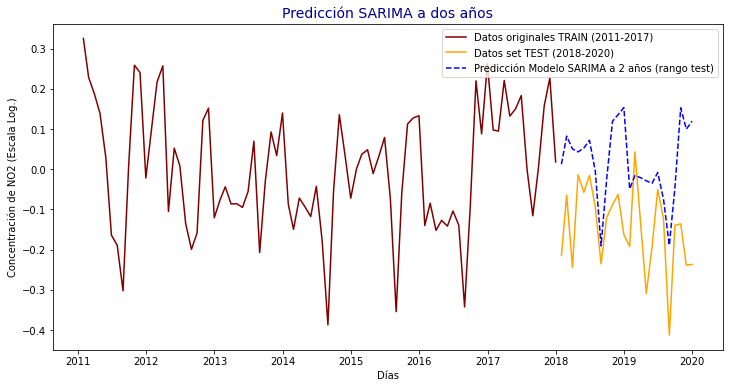

In [59]:
plt.figure(num=1, figsize=(12, 6)) 

plt.plot(train_log_trend, color='maroon', label = 'Datos originales TRAIN (2011-2017)')
plt.plot(test_log_trend, color='orange', label = 'Datos set TEST (2018-2020)')
plt.plot(pred2añosSARIMAX, color='blue', linestyle='dashed', label = 'Predicción Modelo SARIMA a 2 años (rango test)') 
plt.xlabel('Días') 
plt.ylabel('Concentración de NO2 (Escala Log.)')
ax = plt.gca()
plt.title("Predicción SARIMA a dos años", fontsize = 14, color = 'darkblue')
plt.legend(loc="upper right");
plt.show()

###  Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Añade a la serie anterior de previsiones del modelo la tendencia que habíamos eliminado anteriormente.

Hacemos un gráfico de toda serie temporal, sin heterocedasticidad pero con tendencia, diferenciando con dos colores diferentes la serie real en el conjunto de train y las previsiones del modelo en los dos años del conjunto de test.
</div>

In [60]:
# Creamos una nueva variable como suma de predicción del SARIMAX y las predicciones del set de test con el modelo de regresión (que hemos guardado antes en la variable prediccionesNO2_test)
pred2añosSARIMAXtend = pred2añosSARIMAX + prediccionesNO2_test


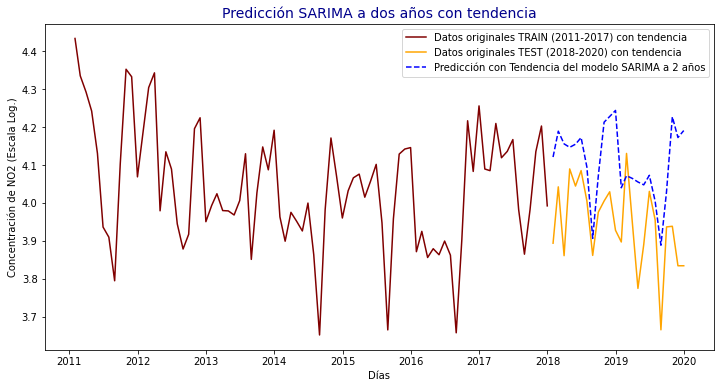

In [61]:
plt.figure(num=1, figsize=(12, 6)) 

plt.plot(train_log_trend+prediccionesNO2, color='maroon', label = 'Datos originales TRAIN (2011-2017) con tendencia')
plt.plot(test_log_trend+prediccionesNO2_test, color='orange', label = 'Datos originales TEST (2018-2020) con tendencia')
plt.plot(pred2añosSARIMAXtend, color='blue', linestyle='dashed', label = 'Predicción con Tendencia del modelo SARIMA a 2 años') 
plt.xlabel('Días') 
plt.ylabel('Concentración de NO2 (Escala Log.)')
ax = plt.gca()
plt.title("Predicción SARIMA a dos años con tendencia", fontsize = 14, color = 'darkblue')
plt.legend();
plt.show()

###  Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
Añadimos a la serie anterior las previsiones del modelo (a la que ya ha recuperado la tendencia), la heterocedasticidad que habíamos eliminado , aplicando la función inversa a la aplicada anteriormente. 
    
Mostrar gráficamente toda la serie, esta vez ya con heterocedasticidad y tendencia,  diferenciando con colores diferentes la serie real de los dos años de predicción. 
</div>

In [62]:
# Aplicamos la función exp de Pandas que calcula la inversa del logaritmo a nuestros datos de la celda anterior.
pred2añosSARIMAXtendhtskct = np.exp(pred2añosSARIMAXtend)

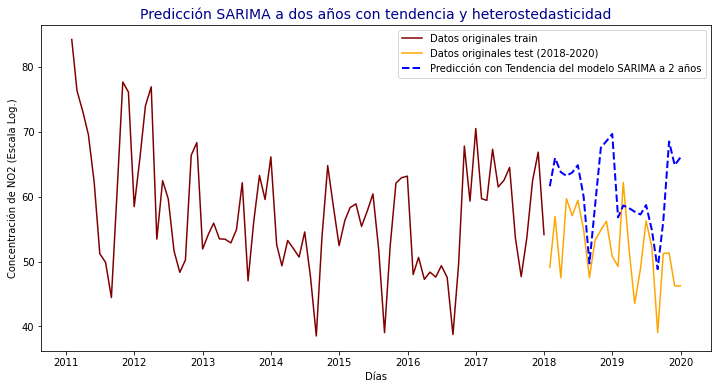

In [63]:
plt.figure(num=1, figsize=(12, 6)) 

plt.plot(np.exp(train_log_trend + prediccionesNO2), color='maroon', label = 'Datos originales train')
plt.plot(np.exp(test_log_trend + prediccionesNO2_test), color='orange', label = 'Datos originales test (2018-2020)')
plt.plot(pred2añosSARIMAXtendhtskct, color='blue', linestyle='dashed', linewidth=2, label = 'Predicción con Tendencia del modelo SARIMA a 2 años') 
plt.xlabel('Días') 
plt.ylabel('Concentración de NO2 (Escala Log.)')
ax = plt.gca()
plt.title("Predicción SARIMA a dos años con tendencia y heterostedasticidad", fontsize = 14, color = 'darkblue')
plt.legend();
plt.show()

###  Precisión del modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Añade al gráfico anterior la serie real para los dos años de predicción.
</div>

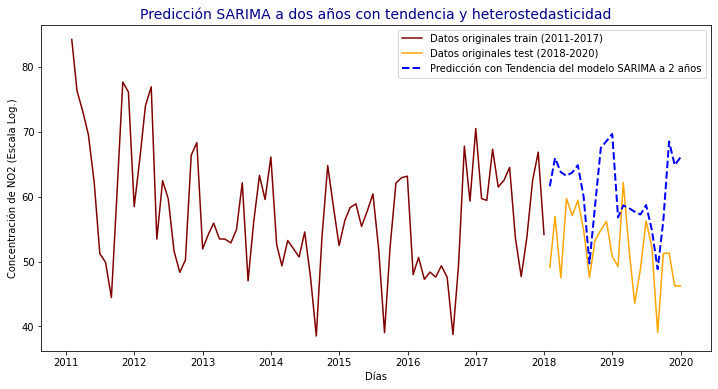

In [64]:
plt.figure(num=1, figsize=(12, 6)) 

plt.plot(np.exp(train_log_trend + prediccionesNO2), color='maroon', label = 'Datos originales train (2011-2017)')
plt.plot(np.exp(test_log_trend + prediccionesNO2_test), color='orange', label = 'Datos originales test (2018-2020)')
plt.plot(pred2añosSARIMAXtendhtskct, color='blue', linestyle='dashed', linewidth=2, label = 'Predicción con Tendencia del modelo SARIMA a 2 años') 
plt.xlabel('Días') 
plt.ylabel('Concentración de NO2 (Escala Log.)')
ax = plt.gca()
plt.title("Predicción SARIMA a dos años con tendencia y heterostedasticidad", fontsize = 14, color = 'darkblue')
plt.legend();
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    

Calcula la precisión del modelo en el conjunto de test con las métricas R2 y Mean Absolute Error.
</div>

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Calculo del MAE mediante sklearn mean_absolute_error(real, predicción)
mae = mean_absolute_error(test, pred2añosSARIMAXtendhtskct)

# Calculo del R^2  mediante sklearn r2_score(real, predicción)
rcuadrado = r2_score(test, pred2añosSARIMAXtendhtskct)

print('Mean Absolut Error (MAE): {}\n'.format(mae))

print('R^2: {}\n'.format(rcuadrado))


# Descomentar para ver MSE y SMSE
# Calculo del MSE  mediante sklearn mean_squared_error(real, predicción)
# mse = mean_squared_error(test, pred2añosSARIMAXtendhtskct)
#print('MSE: {}\n'.format(mse))
# Calculo del SMSE  mediante Numpy np.root(mean_squared_error(real, predicción))
#print('SMSE: {}'.format(np.sqrt(mse)))

Mean Absolut Error (MAE): 9.396300840059302

R^2: -3.1172630262787484



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> ¿Que te parecen los resultados obtenidos por el modelo, tanto visualmente como analizando los valores de las métricas calculadas?
</div>

Las métricas de este último modelo son bastante pobres, en particular $R^2$.¿Significa esto que el modelo es malo o ajusta muy mal? No necesariamente. En realidad, estamos usando un indicado o medidor de bondad que no corresponde al 100% con un análisis de series temporales como el efectuado. Podemos ver que la predicción sigue más fielmente 'lo que podíamos esperar' si observásemos un patrón constante en nuestra serie. Los años predichos (2018-2020) se 'parecen' más a los años anteriores que a los datos del conjunto de test. Esto es lo que cabría esperar quizás. En los años 2011 a 2017 vemos que los tres o cuatro primeros meses del año presentan unos picos, y depués el NO2 vá descendiendo. Esto es lo que el modelo 'ha aprendido' y lo que cabe esperar de su predicción. En cambio el comportamiento de 2018-2020 es algo diferente, más errático y desfasado si cabe que los años anteriores. Probablemente existirá alguna buena explicación: ¿regulación del tráfico más severa? ¿alguna ley de reduccińo de emisiones? Muchas cosas pueden haber influido para este aparente 'cambio de ciclo' o cambio de comportamiento.

Además, en cuanto al cálculo de $R^2$ en este caso no nos proporciona una bondad ya que no estamos haciendo una regresión en el sentido tradicional. Para empezar no tenemos un término constante en los modelos ARIMA (incluido SARIMA) y nuestros residuos sabemos que no suman cero para el conjunto de test. Por otro lado es posible que los años que estamos considerando sean lo suficientemente diferentes para que el modelo haya ajustado en exceso en el modelo de train y no predice nada bien los años de test, dando como resultado un R muy bajo. Es decir, en ambos casos estamos construyendo una medida que no es del todo representativa de los errores en un conjunto de test que, por diversos motivos o motivos que no se presentan en el conjunto de train, se comporta de forma bastante diferente al conjunto de test donde realizamos las predicciones. Obviamente los errores en este caso son de más variabilidad y por tanto $R^2$ produce un valor nada bueno en términos tradicionales.  

Visualmente vemos dos líneas sensiblemente diferentes, con variabilidades y estimaciones muy diferentes. Está claro que no ha resultado ser un muy buen modelo predictivo. Quizás deberíamos repensar los tramos (ir por cuatrimestres quizás?) o escoger únicamente años más recientes (?) y ponderar más los años más recientes con algún tipo de weight o pesos en el modelo y/o en el análisis.